# Study Cases

## Objectives

- Evaluate the effectiveness of resampling methods for hypothesis testing on different datasets.
- Compare results from bootstrap and permutation tests under various conditions.
- Determine statistical significance and differences in data groups using confidence intervals and Bonferroni correction.

## Background

This study pioneers applying resampling techniques, specifically bootstrap and permutation tests, to analyze real-world data. By simulating multiple scenarios with these techniques, we can estimate the significance of differences observed in sample data, thereby revolutionizing decision-making in research and data analysis.

## Datasets Used

- **Tips Dataset**: This dataset includes variables such as total bill, tip, gender, smoking status, and day of the week from a restaurant.
- **Glass Identification Dataset**: Consists of measurements like refractive index and various oxide concentrations used to classify types of glass.
- **Student Performance Dataset**: Contains student grades across three school periods alongside demographic and social factors.

## Introduction

This notebook will show how to apply the resampling techniques for solving hypothesis tests to some real-world data. We are going to use the library  resampling.py

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 8)
pd.set_option('display.float_format', '{:.2f}'.format)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from itertools import combinations
import string

from goliath_research import resampling as rs 

## Resampling

In [2]:
def plot_bars(data, kind_test = 'Bootstrap', kind_sample = 'Independent', title=''):
    '''
    Plot bars with p-value for a permutation or bootstrap test 
    data:        dictionary where keys are the variable names and values are data values    
    kind_sample: 'Independent' or 'Related'
    kind_tast:   'Permutation' or 'Bootstrap'
    title:       title of the plot    
    '''
    # Number of samples
    k = len(data)          
    if k < 2:
        print('Error: at least two samples required!')
        return None            
    # Computing the p-value
    if kind_sample == 'Independent':        # Independent samples
        if kind_test == 'Permutation':      # Permutation test
            p_val = rs.PermutationIndependentHT(*data.values()).get_p_value()
            p_val_text = 'Permutation Test p-value = %.4f' % p_val
        else:                               # Bootstrap test   
            p_val = rs.BootstrapIndependentHT(*data.values()).get_p_value()
            p_val_text = 'Bootstrap Test p-value = %.4f' % p_val
    else:                                   # Related samples
        if kind_test == 'Permutation':      # Permutation test
            p_val = rs.PermutationRelatedHT(*data.values()).get_p_value()
            p_val_text = 'Permutation Test p-value = %.4f' % p_val
        else:                               # Bootstrap test              
            p_val = rs.BootstrapRelatedHT(*data.values()).get_p_value()
            p_val_text = 'Bootstrap Test p-value = %.4f' % p_val
    # Is the p-value significant?            
    if p_val < 0.01:
        p_val_text = p_val_text + '**'
        comment_text = "** p-value is significant at the 0.01 level"
    elif p_val < 0.05:
        p_val_text = p_val_text + '*'
        comment_text = "* p-value is significant at the 0.05 level"
    else:
        comment_text = "p-value is not significant"
    # Convert data to a DataFrame
    flat_data = [(key, value) for key, values in data.items() for value in values]
    df = pd.DataFrame(flat_data, columns=['Labels', 'Values'])     
    # Plotting 
    fig = sns.catplot(data=df, x='Labels', y='Values', kind='bar', estimator=np.mean, 
        errorbar=('ci', 0))  
    # Add a title 
    fig.set(title = title)  
    # Add a subtitle 
    plt.subplots_adjust(top=0.9) 
    plt.suptitle(p_val_text, fontsize=9, color='gray', x= 0.55, y=0.9)
    # Add the comment at the bottom of the graph
    fig.set_axis_labels("", "Frequency")
    fig.ax.text(0.5, -0.1, comment_text, fontsize=9, color='grey', ha='center', transform=fig.ax.transAxes)  
    return fig

In [3]:
def get_dict(dfr: pd.DataFrame, values, labels) -> dict:
    '''
    df is a DataFrame with at least two columns: values and labels
    It returns a dictionary where keys are unique values of the column 
    "labels" and values are those of column "values".
    '''    
    dictionary = dfr[[values, labels]].groupby(labels, observed=True).groups
    for k in dictionary.keys():
        dictionary[k] = np.array(dfr.loc[dictionary[k], values].values)            
    return dictionary   

In [4]:
def plot_confidence_intervals(data, labels):
    '''
    Plot confidence intervals.
    data:   is a numpy array of tuples, each one represent a confidence interval. 
    labels: is a list of labels for each tuple in data.
    '''
    # Create a new figure object
    fig, ax = plt.subplots()    
    # Separating the x and y coordinates
    x = np.array([(data[i][0]+data[i][1])/2 for i in range(len(data))])
    #y = np.arange(0, len(data), 1)
    y = labels    
    # Drawing small horizontal lines between the min and max for each tuple
    for i in range(len(data)):
        ax.hlines(y[i], min(data[i]), max(data[i]), colors='navy', linestyles='solid')
    # Creating the scatter plot using Seaborn
    sns.scatterplot(x=x, y=y, color='navy', s=80, ax=ax)
    # Labeling the axes and setting the plot title    
    sns.set_context("notebook", rc={"lines.linewidth": 2})
    ax.set_title('Confidence Intervals')
    ax.set_xlabel('Mean')
    ax.set_ylabel('Sample')   
    ax.set_yticks(y)    
    # Return the figure object
    return fig

In [5]:
def plot_bonferroni(data, kind_test = 'Bootstrap',  kind_sample = 'Independent', title=''):
    '''
    Plot bars with p-value for a permutation or bootstrap test 
    data:        dictionary where keys are the variable names and values are data values        
    kind_test:   'Permutation' or 'Bootstrap'
    title:       title of the plot    
    '''
    # Number of samples
    k = len(data)          
    if k < 3:
        print('Error: at least three samples required!')
        return None
    # Computing the p-value
    if kind_sample == 'Independent':        # Independent samples
        if kind_test == 'Permutation':      # Permutation test
            perm = rs.PermutationIndependentHT(*data.values())
            p_val = perm.get_p_value()
            p_val_text = 'Permutation Test p-value = %.4f' % p_val
            bonferroni = perm.get_homogeneous_subsets(0.01)        
        else:                               # Bootstrap test   
            boot = rs.BootstrapIndependentHT(*data.values())
            p_val = boot.get_p_value()
            p_val_text = 'Bootstrap Test p-value = %.4f' % p_val            
            bonferroni = boot.get_homogeneous_subsets(0.01)    
    else:                                   # Related samples 
        if kind_test == 'Permutation':      # Permutation test
            perm = rs.PermutationRelatedHT(*data.values())
            p_val = perm.get_p_value()
            p_val_text = 'Permutation Test p-value = %.4f' % p_val
            bonferroni = perm.get_homogeneous_subsets(0.01)        
        else:                               # Bootstrap test   
            boot = rs.BootstrapRelatedHT(*data.values())
            p_val = boot.get_p_value()
            p_val_text = 'Bootstrap Test p-value = %.4f' % p_val            
            bonferroni = boot.get_homogeneous_subsets(0.01)   
    # Is the p-value significant?            
    if p_val < 0.01:
        p_val_text = p_val_text + '**'
        comment_text = "** p-value is significant at the 0.01 level"
    elif p_val < 0.05:
        p_val_text = p_val_text + '*'
        comment_text = "* p-value is significant at the 0.05 level"
    else:
        comment_text = "p-value is not significant"
    # Bonferroni Correction
    # Generate uppercase letters from 'A' to 'Z'
    letters = list(string.ascii_uppercase)    
    homog_subsets = dict(zip(data.keys(), ['']*len(data)))        
    for i in range(len(bonferroni)):
        subset = bonferroni[i]        
        for j in range(len(subset)):
            key = list(data.keys())[subset[j]]
            homog_subsets[key] = homog_subsets[key] + letters[i]        
    # Convert data to a DataFrame
    flat_data = [(key, value) for key, values in data.items() for value in values]
    df = pd.DataFrame(flat_data, columns=['Labels', 'Values'])     
    # Plotting the data 
    fig = sns.catplot(data=df, x='Labels', y='Values', kind='bar', estimator=np.mean, errorbar=('ci', 0))      
    # Add a title 
    fig.ax.set_title(title, fontsize=14)       
    # Add a subtitle 
    fig.ax.text(0.5, 0.98, p_val_text, fontsize=9, color='grey', ha='center', transform=fig.ax.transAxes) 
    # Add the comment at the bottom of the graph
    fig.set_axis_labels("", "Frequency")
    fig.ax.text(0.5, -0.12, comment_text, fontsize=9, color='grey', ha='center', transform=fig.ax.transAxes) 
    # Add data labels to the bars
    for i, label in enumerate(data.keys()):         
        plt.annotate(homog_subsets[label], (i, data[label].mean()), ha='center', fontsize=9, weight='bold') 
    return fig  

## Tips Dataset

In [6]:
tips = sns.load_dataset("tips")
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


Analyzing `total_bill` by `sex` levels using bootstrap and permutation tests.

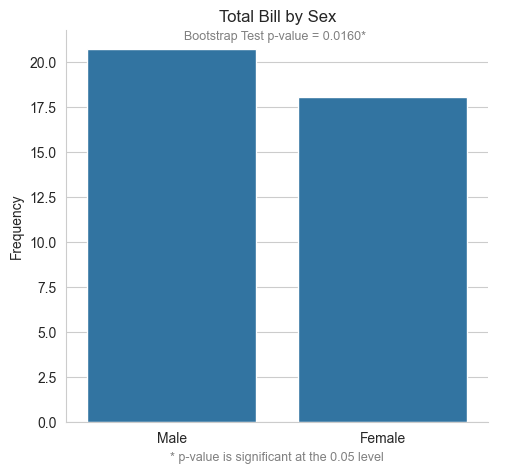

In [7]:
# Bootstrap Test - Independent Samples
data_sex = get_dict(tips, 'total_bill', 'sex')
plot_bars(data_sex, 'Bootstrap', 'Independent', 'Total Bill by Sex');

According to the bootstrap test for independent samples, there are significant differences in total bills between males and females.

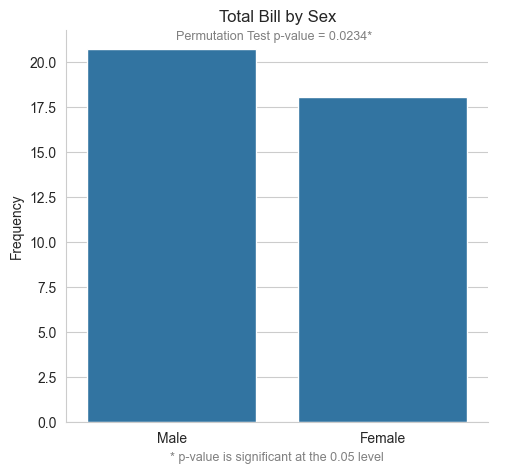

In [8]:
# Permutation Test - Independent Samples
plot_bars(data_sex, 'Permutation', 'Independent', 'Total Bill by Sex');

According to the permutation test for independent samples, there are significant differences in total bills between males and females.

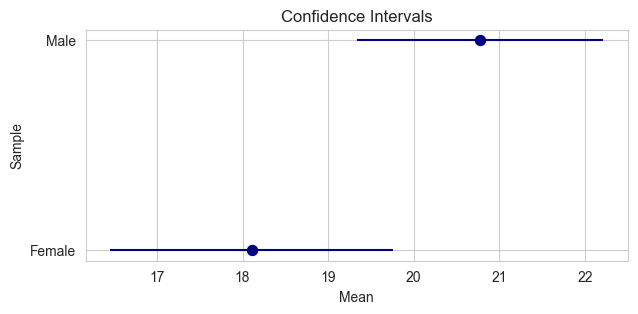

In [9]:
# Plotting Confidence Intervals
ci_sex = plot_confidence_intervals(rs.BootstrapIndependentHT(*data_sex.values()).confidence_intervals(),
                                   list(data_sex.keys()))
ci_sex.set_figwidth(7)          # Update the width
ci_sex.set_figheight(3)         # Update the height

Analyzing `total_bill` by `smoker` levels using bootstrap and permutation tests.

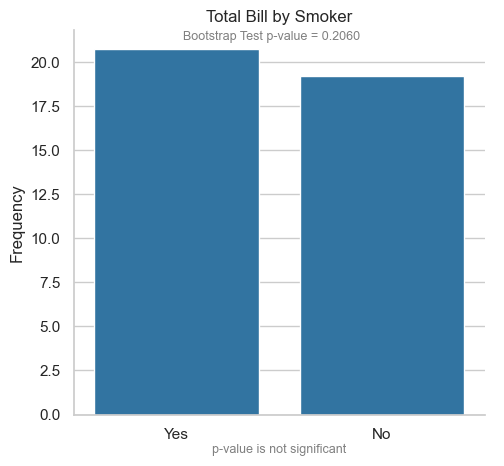

In [10]:
# Bootstrap Test - Independent Samples
data_smk = get_dict(tips, 'total_bill', 'smoker')
plot_bars(data_smk, 'Bootstrap', 'Independent', 'Total Bill by Smoker');

According to the bootstrap test for independent samples, smokers and non-smokers have no significant differences in total bills.

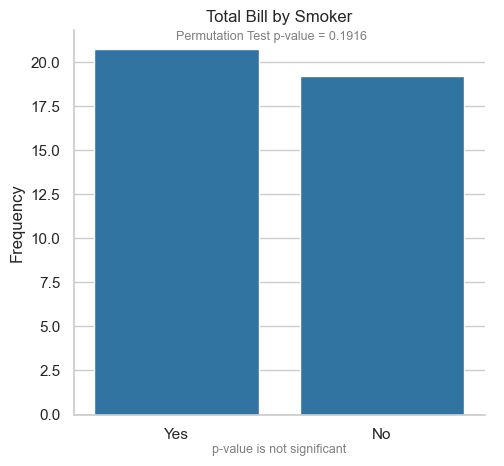

In [11]:
# Permutation Test - Independent Samples
plot_bars(data_smk, 'Permutation', 'Independent', 'Total Bill by Smoker');

According to the permutation test for independent samples, smokers and non-smokers have no significant differences in total bills.

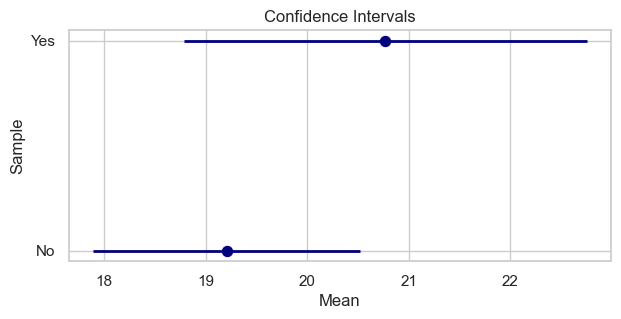

In [12]:
# Plotting Confidence Intervals
ci_smk = plot_confidence_intervals(rs.BootstrapIndependentHT(*data_smk.values()).confidence_intervals(),
                                   list(data_smk.keys()))
ci_smk.set_figwidth(7)          # Update the width
ci_smk.set_figheight(3)         # Update the height

Analyzing `total_bill` by `day` levels using bootstrap and permutation tests.

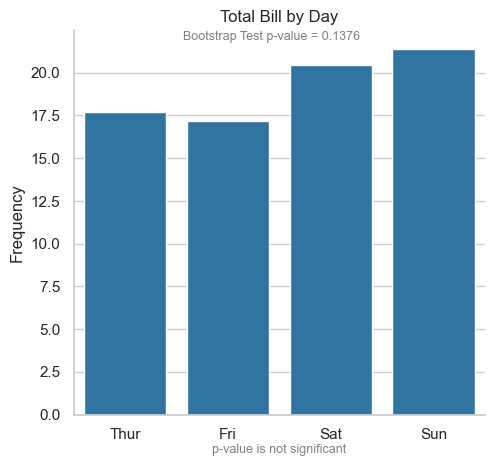

In [13]:
# Bootstrap Test - Independent Samples
data_day = get_dict(tips, 'total_bill', 'day')
plot_bars(data_day, 'Bootstrap', 'Independent', 'Total Bill by Day');

According to the bootstrap test for independent samples, there are no significant differences in total bills between the analyzed days.

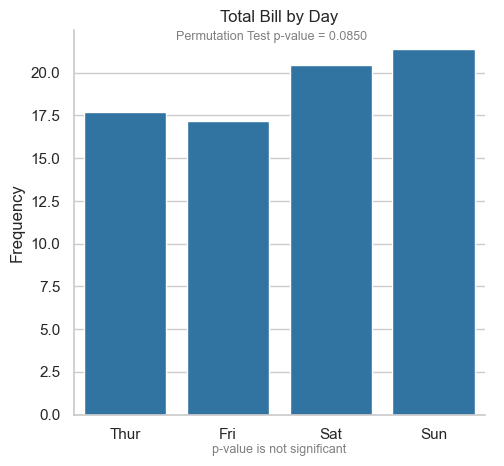

In [14]:
# Permutation Test - Independent Samples
plot_bars(data_day, 'Permutation', 'Independent', 'Total Bill by Day');

According to the permutation test for independent samples, there are no significant differences in total bills between the analyzed days.

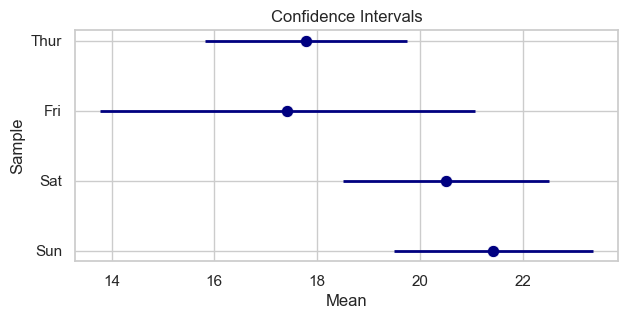

In [15]:
# Plotting Confidence Intervals
ci_day = plot_confidence_intervals(rs.BootstrapIndependentHT(*data_day.values())
                                   .confidence_intervals(), list(data_day.keys()))
ci_day.set_figwidth(7)          # Update the width
ci_day.set_figheight(3)         # Update the height

## Glass Identification Dataset

In [16]:
glass = pd.read_csv('glass.csv')
print(glass.shape)
glass.head()

(214, 10)


,RI,Na,Mg,Al,...,Ca,Ba,Fe,Type
0,1.52,13.64,4.49,1.10,...,8.75,0.00,0.00,1
1,1.52,13.89,3.60,1.36,...,7.83,0.00,0.00,1
2,1.52,13.53,3.55,1.54,...,7.78,0.00,0.00,1
3,1.52,13.21,3.69,1.29,...,8.22,0.00,0.00,1
4,1.52,13.27,3.62,1.24,...,8.07,0.00,0.00,1


Analyzing `Sodium (Na)` by `glass` types using bootstrap and permutation tests.

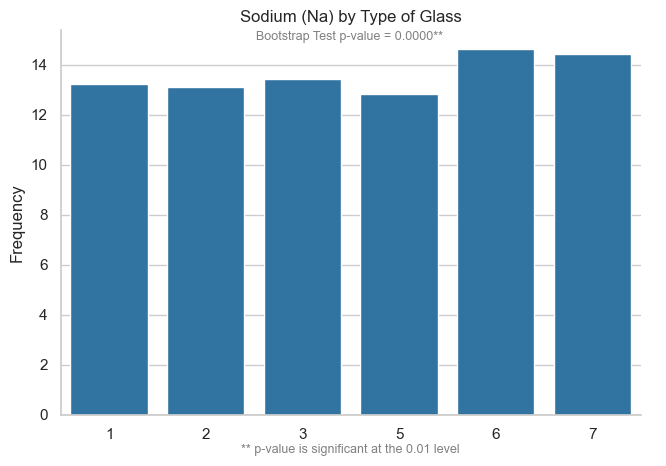

In [17]:
# Bootstrap Test - Independent Samples
data_na = get_dict(glass, 'Na', 'Type')
b_bars_na = plot_bars(data_na, 'Bootstrap', 'Independent', 'Sodium (Na) by Type of Glass')
b_bars_na.figure.set_figwidth(7)             # Update the width
b_bars_na.figure.set_figheight(5)            # Update the height

According to the bootstrap test for independent samples, significant differences exist among the glass types studied in the Sodium (Na) concentration. Here, we have six different glass types: from one to seven, excluding four. We would like to know where the differences are. We will apply multiple test comparisons with the Bonferroni correction for bootstrap tests.

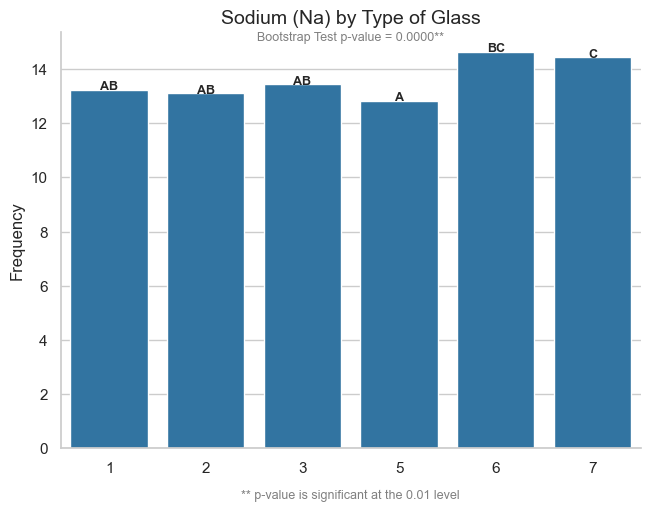

In [18]:
# Bonferroni Correction as multiple comparison test
b_bonf_na = plot_bonferroni(data_na, 'Bootstrap', 'Independent', 'Sodium (Na) by Type of Glass')
b_bonf_na.figure.set_figwidth(7)             # Update the width
b_bonf_na.figure.set_figheight(5)            # Update the heigh

There are three different homogeneous subsets:
- subset **A**: glass type 1, 2, 3, and 5
- subset **B**: glass type 1, 3, and 6
- subset **C**: glass type 6 and 7

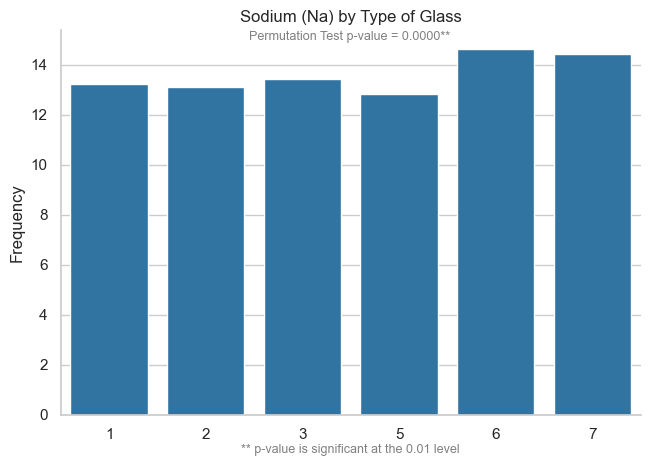

In [19]:
# Permutation Test - Independent Samples
p_bars_na = plot_bars(data_na, 'Permutation', 'Independent', 'Sodium (Na) by Type of Glass')
p_bars_na.figure.set_figwidth(7)             # Update the width
p_bars_na.figure.set_figheight(5)            # Update the height

According to the permutation test for independent samples, significant differences exist among the glass types studied in the Sodium (Na) concentration. Here, we have six different glass types: from one to seven, excluding four. We would like to know where the differences are. We will apply multiple test comparisons with the Bonferroni correction por permutation tests.

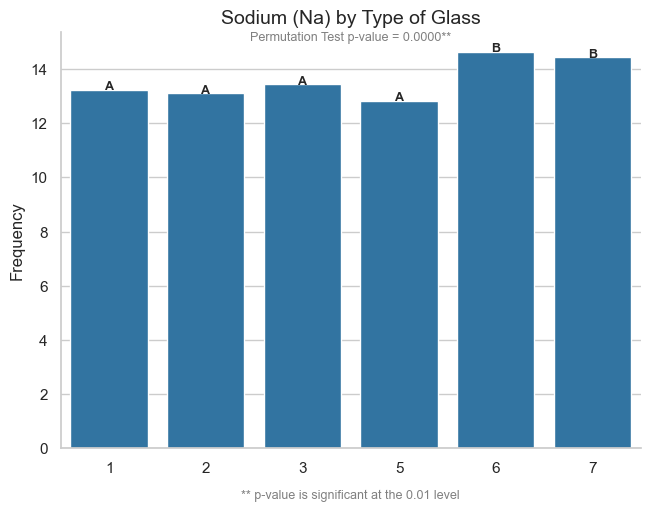

In [20]:
# Bonferroni Correction as multiple comparison test
p_bonf_na = plot_bonferroni(data_na, 'Permutation', 'Independent', 'Sodium (Na) by Type of Glass')
p_bonf_na.figure.set_figwidth(7)             # Update the width
p_bonf_na.figure.set_figheight(5)            # Update the heigh

According to the permutation tests, the homogeneous subsets are not precisely the same as in bootstrap tests. 

Plotting the confidence intervals can give us a better idea of the differences among the groups.

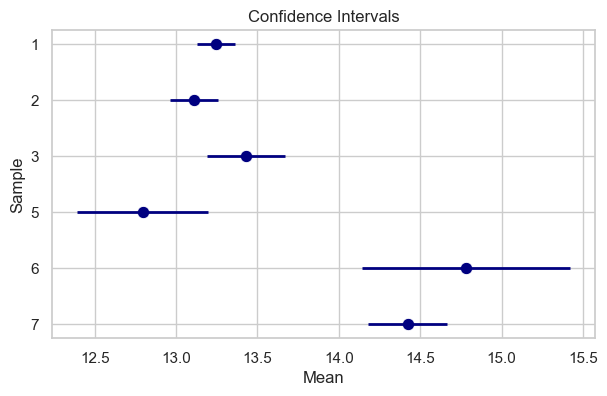

In [21]:
# Plotting Confidence Intervals
keys = [str(key) for key in list(data_na.keys())]
ci_na = plot_confidence_intervals(rs.BootstrapIndependentHT(*data_na.values())
                                .confidence_intervals(), keys)
ci_na.set_figwidth(7)          # Update the width
ci_na.set_figheight(4)         # Update the height

## Student Performance Dataset

In [22]:
stud = pd.read_csv('student-mat.csv', sep=';')
print(stud.shape)
stud.head()

(395, 33)


,school,sex,age,address,...,absences,G1,G2,G3
0,GP,F,18,U,...,6,5,6,6
1,GP,F,17,U,...,4,5,5,6
2,GP,F,15,U,...,10,7,8,10
3,GP,F,15,U,...,2,15,14,15
4,GP,F,16,U,...,4,6,10,10


Let's work with the variables:
- **G1**: first period grade (*numeric*: from 0 to 20)
- **G2**: second period grade (*numeric*: from 0 to 20)
- **G3**: final grade (*numeric*: from 0 to 20, output target)

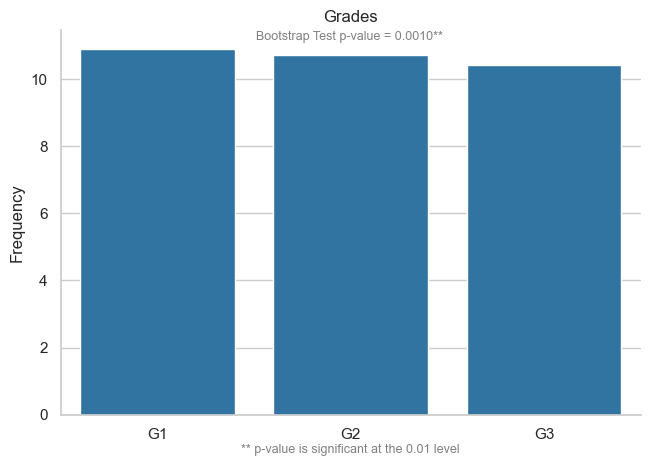

In [23]:
# Bootstrap Test - Related Samples
data_st = {'G1': stud.G1.values, 'G2': stud.G2.values, 'G3': stud.G3.values}
b_bars_st = plot_bars(data_st, 'Bootstrap', 'Related', 'Grades')
b_bars_st.figure.set_figwidth(7)             # Update the width
b_bars_st.figure.set_figheight(5)            # Update the height

According to the bootstrap test for related samples, significant differences exist in the three grades studied.

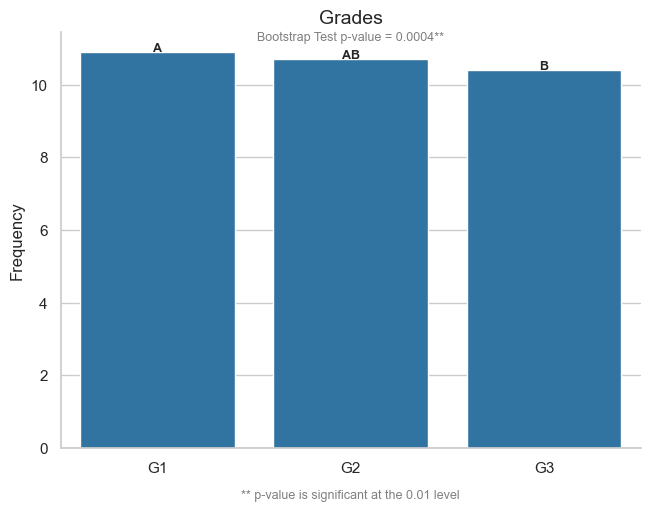

In [24]:
# Bonferroni Correction as multiple comparison test
b_bonf_na = plot_bonferroni(data_st, 'Bootstrap', 'Related', 'Grades')
b_bonf_na.figure.set_figwidth(7)             # Update the width
b_bonf_na.figure.set_figheight(5)            # Update the heigh

Bonferroni correction for multiple testing comparisons shows G2 as an intermediate group between G1 and G3. G2 does not have significant differences with G1 or G3, but G1 and G3 have substantial differences.

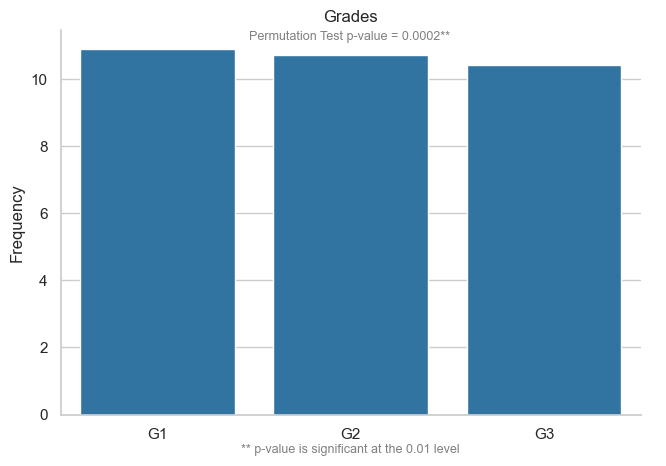

In [25]:
# Permutation Test - Related Samples
p_bars_st = plot_bars(data_st, 'Permutation', 'Related', 'Grades')
p_bars_st.figure.set_figwidth(7)             # Update the width
p_bars_st.figure.set_figheight(5)            # Update the height

According to the permutation test for related samples, significant differences exist in the three grades studied.

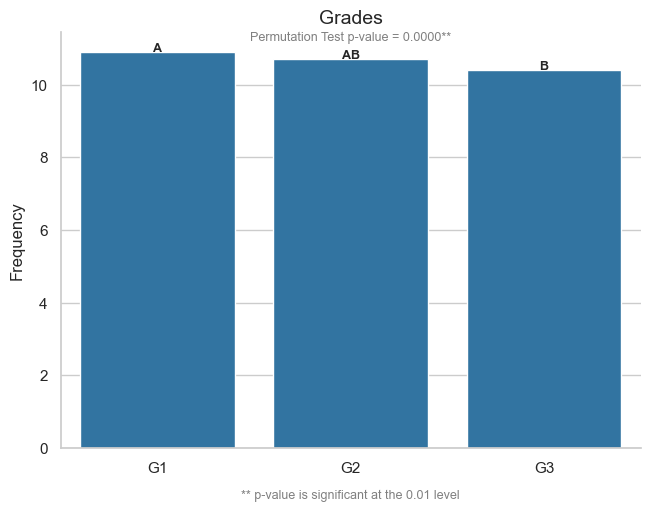

In [26]:
# Bonferroni Correction as multiple comparison test
p_bonf_st = plot_bonferroni(data_st, 'Permutation', 'Related', 'Grades')
p_bonf_st.figure.set_figwidth(7)             # Update the width
p_bonf_st.figure.set_figheight(5)            # Update the heigh

Bonferroni correction for multiple testing comparisons shows G2 as an intermediate group between G1 and G3. G2 does not have significant differences with G1 or G3, but G1 and G3 have substantial differences.

In this case, bootstrap and permutation approaches produce the same results. Let's plot the confidence intervals.

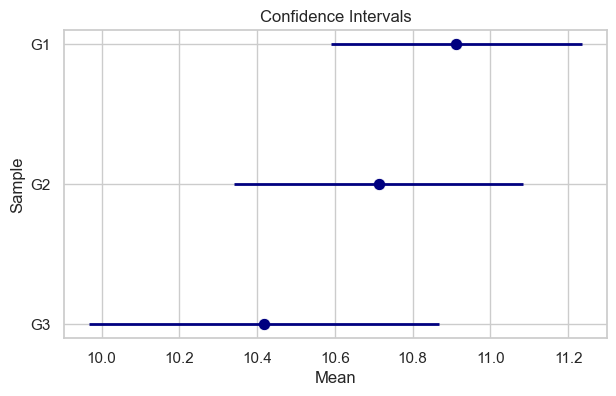

In [27]:
# Plotting Confidence Intervals
ci_st = plot_confidence_intervals(rs.BootstrapRelatedHT(stud.G1, stud.G2, stud.G3)
                                .confidence_intervals(), ['G1', 'G2', 'G3'])
ci_st.set_figwidth(7)          # Update the width
ci_st.set_figheight(4)         # Update the height

## Conclusions

Key Takeaways:
- Both bootstrap and permutation tests consistently identified significant differences in total bill amounts between different groups in the tips dataset.
- In the glass dataset, significant variations in sodium levels across glass types were detected, which were further analyzed using the Bonferroni correction to understand group homogeneity.
- For the student performance data, significant differences between the grades over three terms were confirmed, highlighting variations in academic performance across terms.

## References

- Cortez,Paulo. (2014). Student Performance. UCI Machine Learning Repository. https://doi.org/10.24432/C5TG7T.
- German,B.. (1987). Glass Identification. UCI Machine Learning Repository. https://doi.org/10.24432/C5WW2P.